Reference: https://www.kaggle.com/datasets/shivamb/netflix-shows/code

In [1]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Load the data

In [3]:
# load the data
df = pd.read_csv('MyDrive/IDS_Datasets/netflix_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head(10)

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,...,listed_in,description,year,month,day,kfold,directors,categories,actors,countries
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,...,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,25.0,0,[Kirsten Johnson],[Documentaries],[],[United States]
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,...,International,"After crossing paths at a party, a Cape Town t...",2021.0,9.0,24.0,0,[],[International],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[South Africa]
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,...,Crime,To protect his family from a powerful drug lor...,2021.0,9.0,24.0,0,[Julien Leclercq],[Crime],"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[]
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,...,Docuseries,"Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,24.0,0,[],[Docuseries],[],[]
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,...,International,In a city of coaching centers known to train I...,2021.0,9.0,24.0,0,[],[International],"[Mayur More, Jitendra Kumar, Ranjan Raj, Alam ...",[India]
5,5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,2021-09-24,2021,TV-MA,...,TV,The arrival of a charismatic young priest brin...,2021.0,9.0,24.0,0,[Mike Flanagan],[TV],"[Kate Siegel, Zach Gilford, Hamish Linklater, ...",[]
6,6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021-09-24,2021,PG,...,Children,Equestria's divided. But a bright-eyed hero be...,2021.0,9.0,24.0,0,"[Robert Cullen, José Luis Ucha]",[Children],"[Vanessa Hudgens, Kimiko Glenn, James Marsden,...",[]
7,7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,...,Dramas,"On a photo shoot in Ghana, an American model s...",2021.0,9.0,24.0,0,[Haile Gerima],[Dramas],"[Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra ...","[United States, Ghana, Burkina Faso, United Ki..."
8,8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,2021-09-24,2021,TV-14,...,British,A talented batch of amateur bakers face off in...,2021.0,9.0,24.0,0,[Andy Devonshire],[British],"[Mel Giedroyc, Sue Perkins, Mary Berry, Paul H...",[United Kingdom]
9,9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,...,Comedies,A woman adjusting to life after a loss contend...,2021.0,9.0,24.0,0,[Theodore Melfi],[Comedies],"[Melissa McCarthy, Chris O'Dowd, Kevin Kline, ...",[United States]


In [4]:
print(df.shape)

(8807, 21)


# KMeans clustering with TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(df['description'].apply(lambda x: np.str_(x)) )

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df['description'].apply(lambda x: np.str_(x)))
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


137    6579
62      752
109     308
23      272
52      206
Name: cluster, dtype: int64

<div class="alert alert-block alert-warning"><span>&#171;</span>column cluster are not going to be used because clusters are two unbalanced <br/> But tfidf will be used in order to find similar description<span>&#187;</span></div>

In [6]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

# Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Categorie
* Countrie
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>


In [7]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.11492466926574707 seconds --
 iter 1000 -- 15.108025550842285 seconds --
 iter 2000 -- 23.095531702041626 seconds --
 iter 3000 -- 28.72805118560791 seconds --
 iter 4000 -- 34.33607268333435 seconds --
 iter 5000 -- 39.881351709365845 seconds --
 iter 6000 -- 45.68910217285156 seconds --
 iter 7000 -- 51.08792734146118 seconds --
 iter 8000 -- 56.50994849205017 seconds --
 finish -- 61.04601526260376 seconds --


# To see what's going on,a sub-graph with only two movies ...

In [8]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



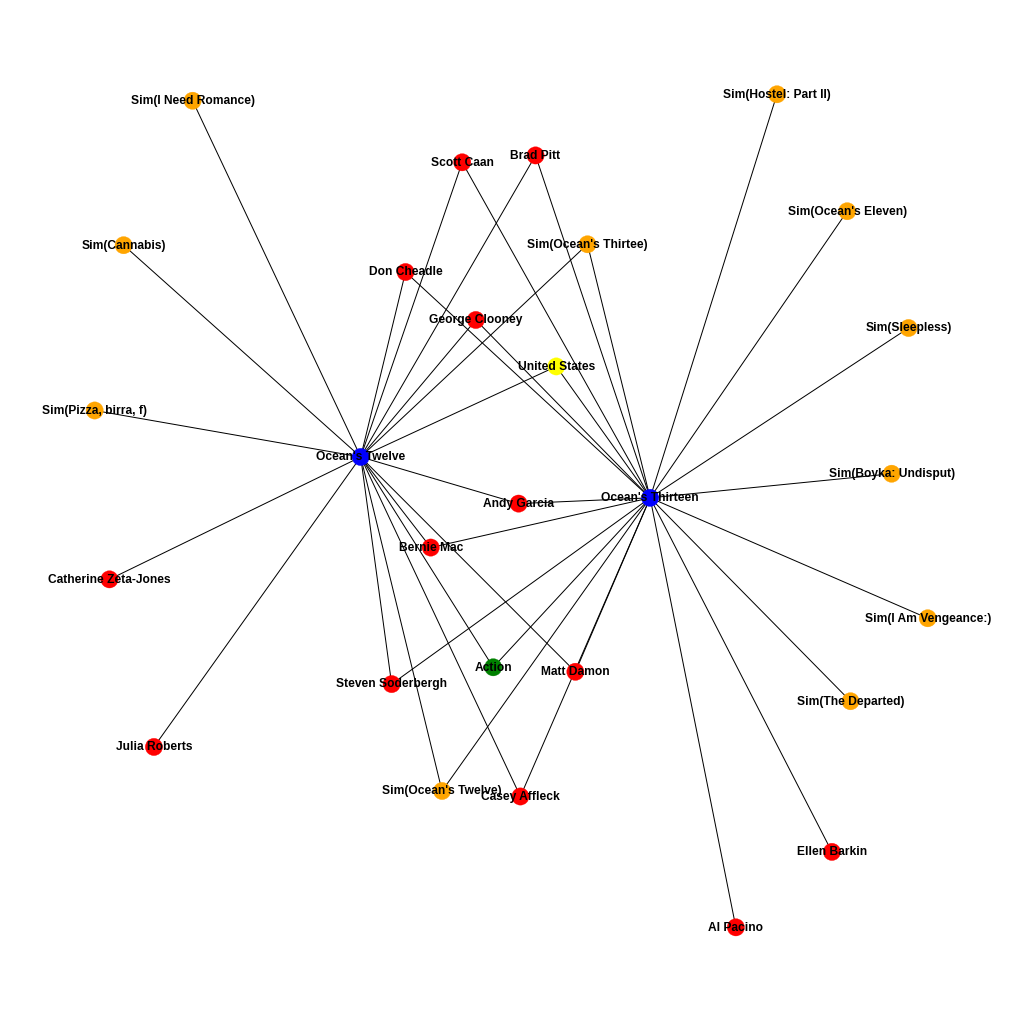

In [9]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calcul Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [10]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

# Let's test it ...

In [11]:
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen    6.076190
Ocean's Eleven      1.385995
Sleepless           1.385995
Babel               1.160762
I Need Romance      1.116221
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       6.076190
The Departed         2.213117
Ocean's Eleven       1.944106
Hostel: Part III     1.796084
Brooklyn's Finest    1.449024
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Boy                                  1.742486
Lying and Stealing                       1.564448
The Devil and Father Amorth              1.237974
Making a Murderer                        1.237974
Belief: The Possession of Janet Moses    1.116221
dtype: float64
****************************************
 Recommendation 

# Draw top recommendations, to see the common nodes

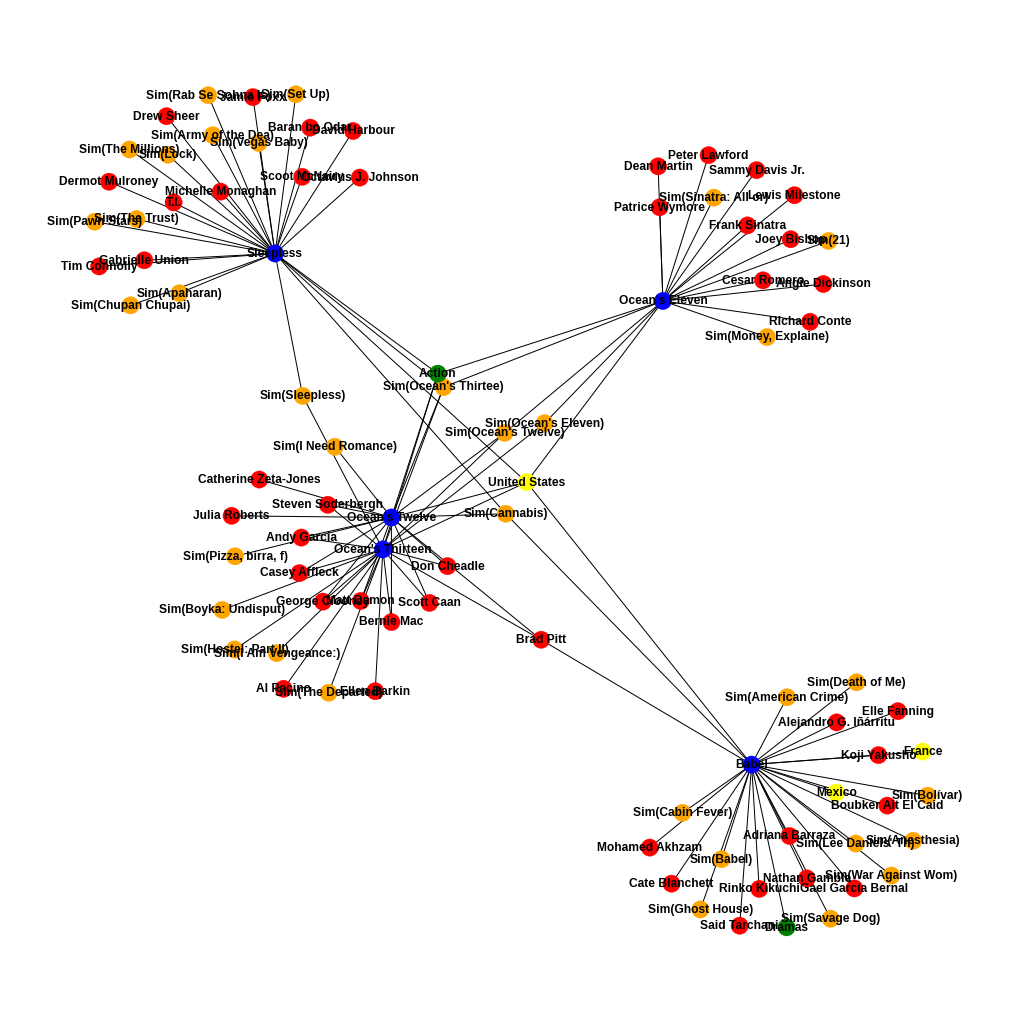

In [12]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

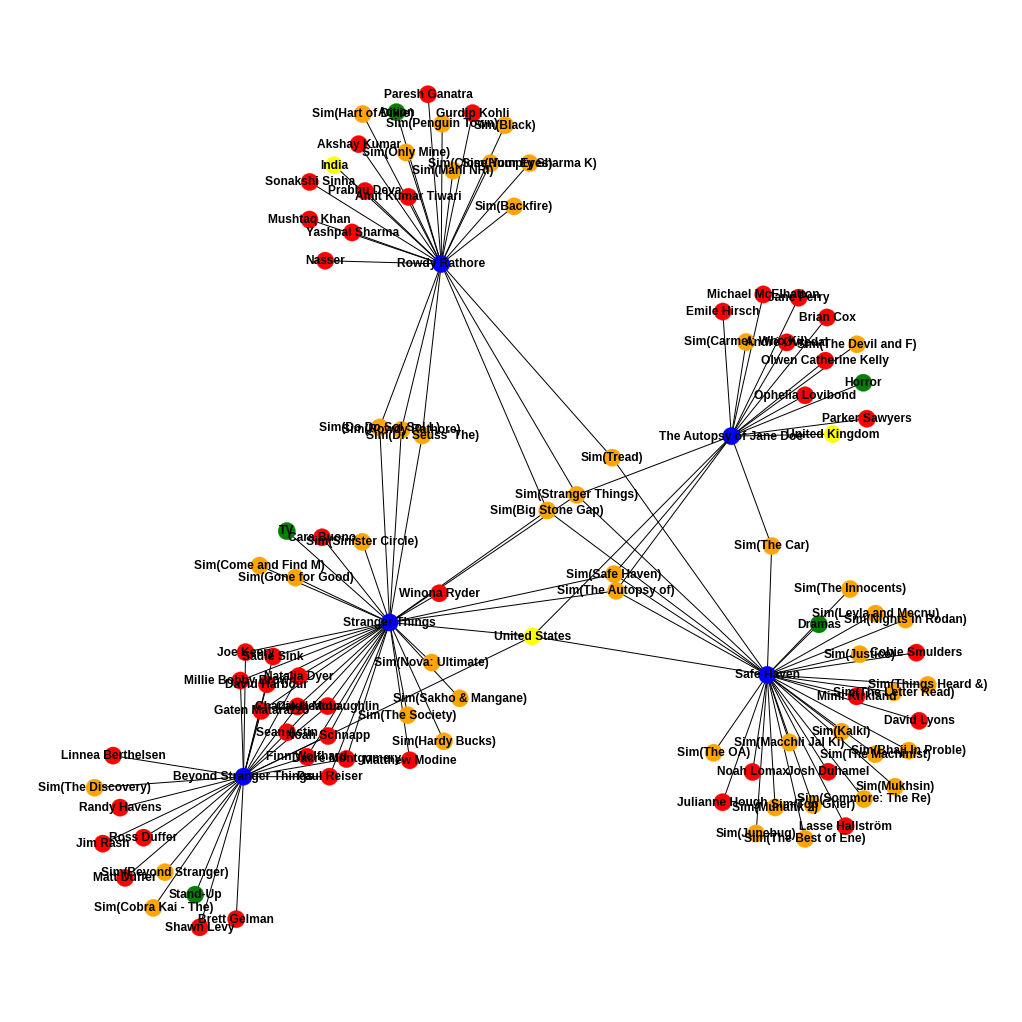

In [13]:
reco=list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)